This notebook includes the notes and the exercises of Week 5 of Crash course in Causality, Penn University

Colab Link: https://colab.research.google.com/drive/1qM1k6KrgR8eGTptWs3RlPql5UJ41RWPz

References:
- Crash course in Causality, Penn University, Coursera
- https://cran.r-project.org/web/packages/ivpack/ivpack.pdf
- http://utstat.toronto.edu/~nathan/teaching/STA305/classnotes/week4/sta305week4classnotes.html

# Set Environment


In [1]:
#set R environment
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


In [2]:
install.packages("ivpack")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘data.table’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘car’, ‘zoo’, ‘Formula’, ‘AER’, ‘sandwich’, ‘lmtest’




In [3]:
#load packages
library(ivpack)

Loading required package: AER

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



# Load Data

In [0]:
data(card.data)

[1] "id"       "nearc2"   "nearc4"   "educ"     "age"      "fatheduc"
 [7] "motheduc" "weight"   "momdad14" "sinmom14" "step14"   "reg661"  
[13] "reg662"   "reg663"   "reg664"   "reg665"   "reg666"   "reg667"  
[19] "reg668"   "reg669"   "south66"  "black"    "smsa"     "south"   
[25] "smsa66"   "wage"     "enroll"   "KWW"      "IQ"       "married" 
[31] "libcrd14" "exper"    "lwage"    "expersq"  "region"

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,⋯,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq,region
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
1,2,0,0,7,29,NA,NA,158413,1,0,⋯,548,0,15,NA,1,0,16,6.306275,256,661
2,3,0,0,12,27,8,8,380166,1,0,⋯,481,0,35,93,1,1,9,6.175867,81,661
3,4,0,0,12,34,14,12,367470,1,0,⋯,721,0,42,103,1,1,16,6.580639,256,661
4,5,1,1,11,27,11,12,380166,1,0,⋯,250,0,25,88,1,1,10,5.521461,100,662
5,6,1,1,12,34,8,7,367470,1,0,⋯,729,0,34,108,1,0,16,6.591674,256,662
6,7,1,1,12,26,9,12,380166,1,0,⋯,500,0,38,85,1,1,8,6.214608,64,662
7,8,1,1,18,33,14,14,367470,1,0,⋯,565,0,41,119,1,1,9,6.336826,81,662
8,9,1,1,14,29,14,14,496635,1,0,⋯,608,0,46,108,1,1,9,6.410175,81,662
9,10,1,1,12,28,12,12,367772,1,0,⋯,425,0,32,96,4,0,10,6.052089,100,662


[1] 0.6820598

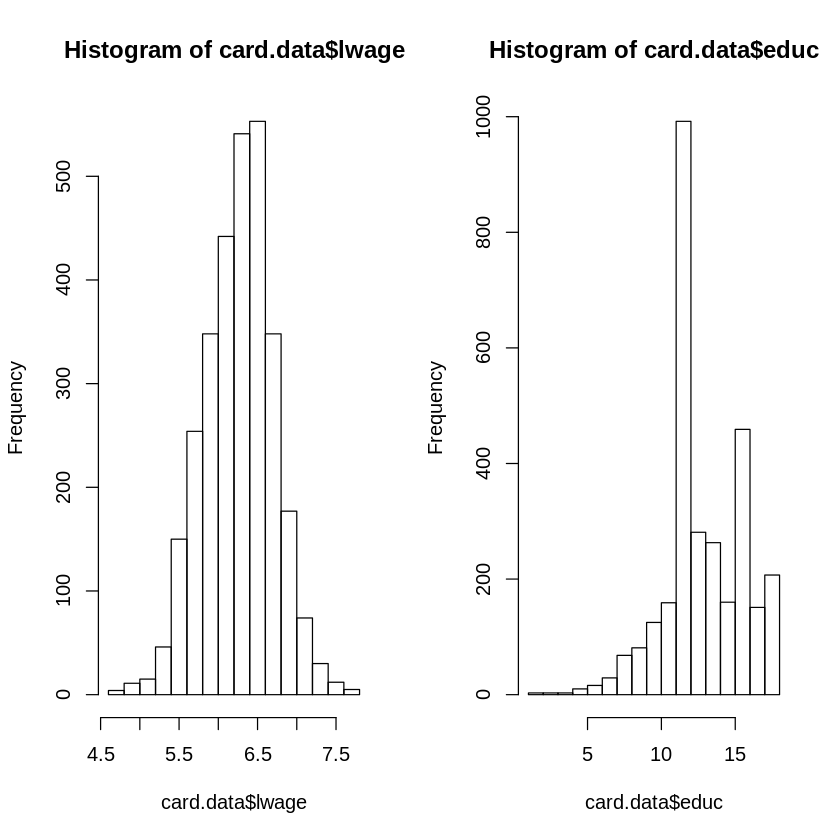

In [5]:
#Instrumental Variables is nearc4 (near 4 year college)
#outcome is lwage (log of wage)
#'treatment' is educ (number of years of education)

#summary stats
colnames(card.data)
head(card.data, 10)
mean(card.data$nearc4)
par(mfrow=c(1,2))
hist(card.data$lwage)
hist(card.data$educ)

## Instrumental Variables

IV is an alternative casual inference method that does not rely on ignorability assumption. 

We analyse the the variables that can influence the treatment, independent of the outcome.  An example is the higher probability to be treated because you live close to a care center, or simply one person is more open to comply to be assigned to treatment or control, or because one drug goes out of fashion and is replaced by another one

![alt text](https://drive.google.com/uc?id=19M3RP9qAFdJ1riM07dDmp9Avfm9ylaDs)


To recap, The ignorability assumption means that if we want to interpret the regression coefficient for treatment as an average causal effect then all the counfounding covariates should be controlled for in the regression model. In a randomized experiments the treatment assignment is ignorable. The treatment assignment should be independant of the potential outcome

In [6]:
#is the IV associated with the treatment? strenght of IV
mean(card.data$educ[card.data$nearc4==1])
mean(card.data$educ[card.data$nearc4==0])

[1] 13.52703

[1] 12.69801

In [7]:
#make education binary
educ12<-card.data$educ>12
#estimate proportion of 'compliers'
propcomp<-mean(educ12[card.data$nearc4==1])-
  mean(educ12[card.data$nearc4==0])
propcomp

[1] 0.1219293

In [8]:
#intention to treat effect
itt<-mean(card.data$lwage[card.data$nearc4==1])-
  mean(card.data$lwage[card.data$nearc4==0])
itt

[1] 0.1559075

In [9]:
#complier average causal effect
itt/propcomp

[1] 1.278672

## two stage least squares

In [10]:
#stage 1: regress A on Z
s1<-lm(educ12~card.data$nearc4)
## get predicted value of A given Z for each subject
predtx <-predict(s1, type = "response")
table(predtx)

predtx
0.422152560083595 0.544081831466148 
              957              2053 

In [11]:
#stage 2: regress Y on predicted value of A
lm(card.data$lwage~predtx)


Call:
lm(formula = card.data$lwage ~ predtx)

Coefficients:
(Intercept)       predtx  
      5.616        1.279  


In [12]:
#2SLS using ivpack
ivmodel=ivreg(lwage ~ educ12, ~ nearc4, x=TRUE, data=card.data)
robust.se(ivmodel)


ivmodel=ivreg(lwage ~ educ12 + exper + reg661 + reg662 +
                reg663 + reg664 + reg665+ reg666 + reg667 + reg668, 
                ~ nearc4 + exper +
                  reg661+ reg662 + reg663 + reg664 + reg665 + reg666 +
                reg667 + reg668, x=TRUE, data=card.data)

[1] "Robust Standard Errors"



t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  5.61570    0.11172 50.2637 < 2.2e-16 ***
educ12TRUE   1.27867    0.22036  5.8026  7.21e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
